In [1]:
import concurrent.futures
import collections
import math
import os
import pathlib
import random
import re
import string
import time
import shutil
import pickle

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import tqdm

import tensorflow as tf
#tf.config.run_functions_eagerly(True)

import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

In [2]:
def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
    def custom_reader_func(datasets):
        datasets = datasets.shuffle(1000)
        return datasets.interleave(lambda x: x, cycle_length=cycle_length)

    ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)
    
    def drop_index(i, x):
        return x
    
    ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
    return ds

In [3]:
train_ds = load_dataset(str(pathlib.Path.cwd() / 'Model_Data/train_cache'))
test_ds = load_dataset(str(pathlib.Path.cwd() / 'Model_Data/test_cache'))

In [4]:
class SeqEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, max_length, depth):
        super().__init__()
        self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)
        
        self.token_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=depth,
            mask_zero=True)
        
        self.add = tf.keras.layers.Add()
    
    def call(self, seq):
        seq = self.token_embedding(seq) # (batch, seq, depth)
        
        x = tf.range(tf.shape(seq)[1])  # (seq)
        x = x[tf.newaxis, :]  # (1, seq)
        x = self.pos_embedding(x)  # (1, seq, depth)
        
        return self.add([seq, x])


class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()


class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn = self.mha(query=x, value=x,
                        use_causal_mask=True)
        x = self.add([x, attn])
        return self.layernorm(x)


class CrossAttention(BaseAttention):
    def call(self, x, y, **kwargs):
        attn, attention_scores = self.mha(
                 query=x, value=y,
                 return_attention_scores=True)
        
        self.last_attention_scores = attention_scores
        
        x = self.add([x, attn])
        return self.layernorm(x)


class FeedForward(tf.keras.layers.Layer):
    def __init__(self, units, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(units=2*units, activation='relu'),
            tf.keras.layers.Dense(units=units),
            tf.keras.layers.Dropout(rate=dropout_rate),
        ])
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()
    
    def call(self, x):
        x = self.add([x, self.seq(x)])
        return self.layernorm(x)


class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, units, num_heads=1, dropout_rate=0.1):
        super().__init__()
        
        self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                                  key_dim=units,
                                                  dropout=dropout_rate)
        self.cross_attention = CrossAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
        self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
    
    
    def call(self, inputs, training=False):
        in_seq, out_seq = inputs
        
        # Text input
        out_seq = self.self_attention(out_seq)
        out_seq = self.cross_attention(out_seq, in_seq)
        self.last_attention_scores = self.cross_attention.last_attention_scores
        out_seq = self.ff(out_seq)
        return out_seq

In [5]:
class TokenOutput(tf.keras.layers.Layer):
    def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
        super().__init__()
        
        self.dense = tf.keras.layers.Dense(
            units=tokenizer.vocabulary_size(), **kwargs)
        self.tokenizer = tokenizer
        self.banned_tokens = banned_tokens
        self.bias = None
    
    def adapt(self, ds):
        counts = collections.Counter()
        vocab_dict = {name: id 
                      for id, name in enumerate(self.tokenizer.get_vocabulary())}
    
        for tokens in tqdm.tqdm(ds):
            counts.update(tokens.numpy().flatten())
        
        counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
        counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())
        
        counts_arr = counts_arr[:]
        for token in self.banned_tokens:
            counts_arr[vocab_dict[token]] = 0
        
        total = counts_arr.sum()
        p = counts_arr/total
        p[counts_arr==0] = 1.0
        log_p = np.log(p)  # log(1) == 0
        
        entropy = -(log_p*p).sum()
        
        print()
        print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
        print(f"Marginal entropy: {entropy:0.2f}")
        
        self.bias = log_p
        self.bias[counts_arr==0] = -1e9

        pickle.dump(self.bias, open(str(pathlib.Path.cwd() / 'Model_Data/bias.pkl'), 'wb'))
        
    
    def call(self, x):
        x = self.dense(x)
        return x + self.bias

In [6]:
def standardize(s):
    s = tf.strings.lower(s)
    s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
    s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
    return s


from_disk = pickle.load(open(str(pathlib.Path.cwd() / 'Model_Data/tokenizer.pkl'), "rb"))
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=from_disk['config']['max_tokens'],
    standardize=standardize,
    ragged=True)
tokenizer.set_weights(from_disk['weights'])

In [7]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:26<00:00, 35.75it/s]


Uniform entropy: 8.52
Marginal entropy: 5.29


In [8]:
class Captioner(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun
    
    def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.word_to_index = tf.keras.layers.StringLookup(
            mask_token="",
            vocabulary=tokenizer.get_vocabulary())
        self.index_to_word = tf.keras.layers.StringLookup(
            mask_token="",
            vocabulary=tokenizer.get_vocabulary(),
            invert=True) 
        
        self.seq_embedding = SeqEmbedding(
            vocab_size=tokenizer.vocabulary_size(),
            depth=units,
            max_length=max_length)
        
        self.decoder_layers = [
            DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
            for n in range(num_layers)]
        
        self.output_layer = output_layer


@Captioner.add_method
def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
        image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')
    
    
    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
        txt = tokenizer(txt)
    
    txt = self.seq_embedding(txt)
    
    # Look at the image
    for dec_layer in self.decoder_layers:
        txt = dec_layer(inputs=(image, txt))
    
    txt = self.output_layer(txt)
    
    return txt

In [9]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Large(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False
'''
if not os.path.exists(pathlib.Path.cwd() / 'Model_Data'):
    os.mkdir(pathlib.Path.cwd() / 'Model_Data')
shutil.move(pathlib.Path.home() / '.keras/models/weights_mobilenet_v3_large_224_1.0_float_no_top_v2.h5', pathlib.Path.cwd() / 'Model_Data/mobilenet_v3_large_weights.h5')
'''

"\nif not os.path.exists(pathlib.Path.cwd() / 'Model_Data'):\n    os.mkdir(pathlib.Path.cwd() / 'Model_Data')\nshutil.move(pathlib.Path.home() / '.keras/models/weights_mobilenet_v3_large_224_1.0_float_no_top_v2.h5', pathlib.Path.cwd() / 'Model_Data/mobilenet_v3_large_weights.h5')\n"

In [10]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

In [11]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
    initial = self.word_to_index([['[START]']]) # (batch, sequence)
    img_features = self.feature_extractor(image[tf.newaxis, ...])
    
    tokens = initial # (batch, sequence)
    for n in range(50):
        preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
        preds = preds[:,-1, :]  #(batch, vocab)
        if temperature==0:
            next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
        else:
            next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
        tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 
        
        if next[0] == self.word_to_index('[END]'):
            break
    words = self.index_to_word(tokens[0, 1:-1])
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    return result.numpy().decode()

In [12]:
def masked_loss(labels, preds):  
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)
    
    mask = (labels != 0) & (loss < 1e8) 
    mask = tf.cast(mask, loss.dtype)
    
    loss = loss*mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_acc(labels, preds):
    mask = tf.cast(labels!=0, tf.float32)
    preds = tf.argmax(preds, axis=-1)
    labels = tf.cast(labels, tf.int64)
    match = tf.cast(preds == labels, mask.dtype)
    acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
    return acc

In [13]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

In [14]:
class GenerateText(tf.keras.callbacks.Callback):
    def __init__(self):
        path = pathlib.Path.cwd() / 'Model_Data'
        image_url = 'https://tensorflow.org/images/surf.jpg'
        image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url, cache_dir=path, cache_subdir=(path / 'train_check'))
        self.image = load_image(image_path)
    
    def on_epoch_end(self, epochs=None, logs=None):
        print()
        print()
        for t in (0.0, 0.5, 1.0):
            result = self.model.simple_gen(self.image, temperature=t)
            print(result)
        print()

In [15]:
model_save = pathlib.Path.cwd() / 'Model_Data/weights/model.tf'

In [16]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        model_save, verbose=1, monitor='val_masked_acc', mode='max', save_best_only=True, save_weights_only=True, save_format='tf')]

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [18]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 4.9664 - masked_acc: 0.2062

a man in a man in the
a man is in the the girl in the man
a behind swimming area


Epoch 1: val_masked_acc improved from -inf to 0.24798, saving model to D:\Projects\Image_Caption\Image-Caption\Model\Model_Data\weights\model.tf
100/100 [==============================] - 20s 138ms/step - loss: 4.9664 - masked_acc: 0.2062 - val_loss: 4.6158 - val_masked_acc: 0.2480
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 4.6209 - masked_acc: 0.2550

a man in a man in the water
a boy on a on a man
a woman is through the an mountain trunks a dog across the rope


Epoch 2: val_masked_acc improved from 0.24798 to 0.28018, saving model to D:\Projects\Image_Caption\Image-Caption\Model\Model_Data\weights\model.tf
100/100 [==============================] - 12s 114ms/step - loss: 4.6191 - masked_acc: 0.2551 - val_loss: 4.3072 - val_masked_acc: 0.2802
Epoch 3/100
100/100 [=============

In [19]:
result = model.simple_gen(load_image(str(pathlib.Path.cwd() / 'Model_Data/train_check/surf.jpg')), temperature=0.0)
result

'a person in a yellow surfboard is riding a wave'

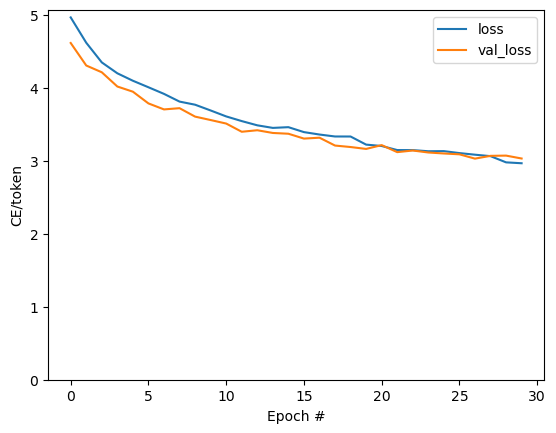

In [20]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

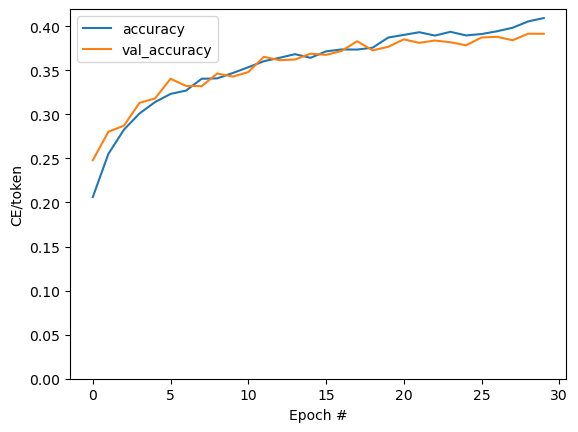

In [21]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [22]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)

    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()
    

@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
    result_txt = self.simple_gen(image, temperature)
    str_tokens = result_txt.split()
    str_tokens.append('[END]')
    
    attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
    attention_maps = tf.concat(attention_maps, axis=0)
    attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
    
    plot_attention_maps(image/255, str_tokens, attention_maps)
    t = plt.suptitle(result_txt)
    t.set_y(1.05)

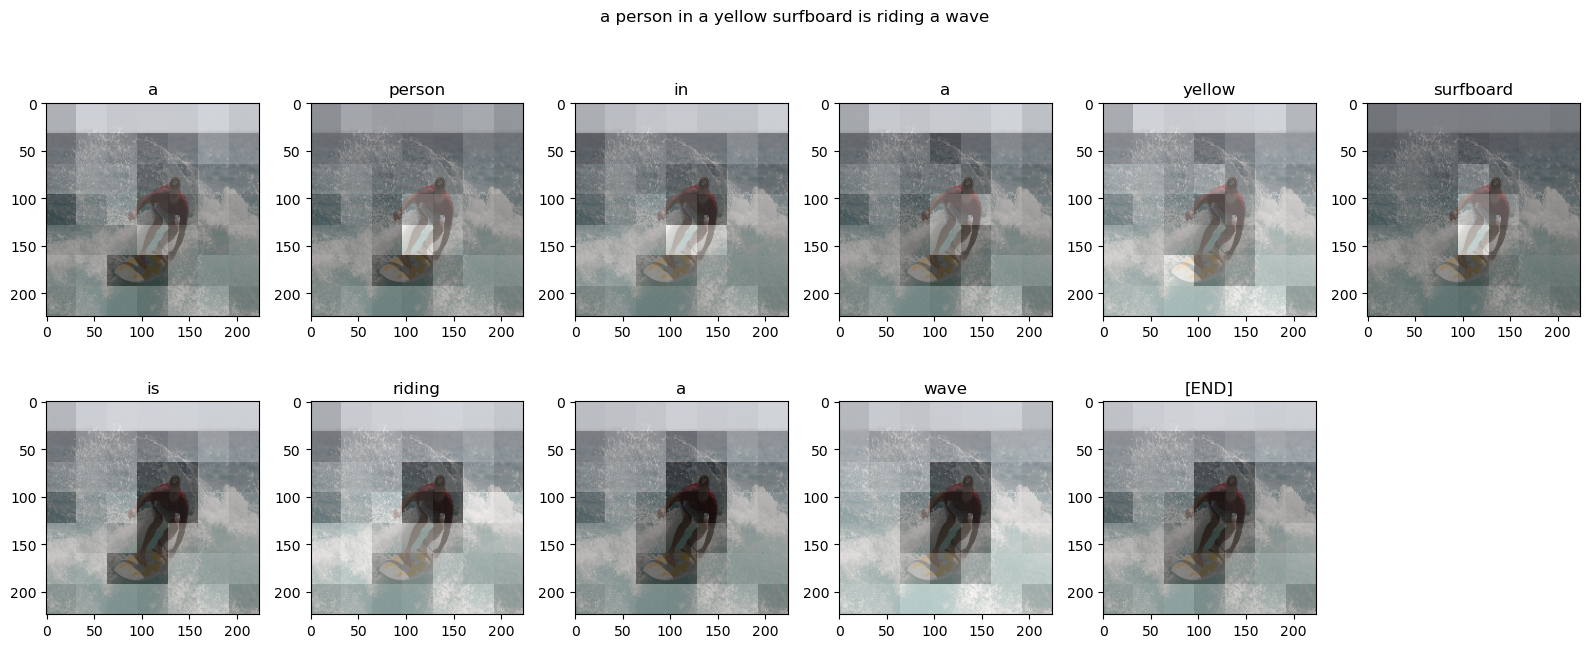

In [23]:
run_and_show_attention(model, load_image(str(pathlib.Path.cwd() / 'Model_Data/train_check/surf.jpg')))